# Clase 4. Preparación de datos. Sección 7. Tratamiento de valores extremos

Este cuaderno contiene los ejemplos en python/SKLearn que acompañan a la [presentación de la clase](https://docs.google.com/presentation/d/1lBF-w7pShz5fd4-LQZvsIUnHJwPomvdqlVNyKYM9Q-M/edit?usp=sharing).

Ejemplos organizados por sección:

- Detección de outliers
    - Método del desvío estándar.
    - Método del rango intercuartil (IQR)
- Tratamiento de outliers
    - Poda
    - 
- Detección y eliminación automática de outliers.

In [1]:
%load_ext autoreload
%autoreload 2

# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_regression

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

np.random.seed(42)

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Pandas",pd.__version__),
    ("Numpy",np.__version__),
    ("Matplotlib",matplotlib.__version__),
    ("SKlearn",sklearn.__version__),
    ("Seaborn",sns.__version__)
]))

Pandas:1.2.3
Numpy:1.19.2
Matplotlib:3.3.4
SKlearn:0.24.1
Seaborn:0.11.1



Datasets.

In [2]:
DATASET_PATH="./data"
!ls {DATASET_PATH}

diabetes.csv
diabetes_ex.csv
houseprices.csv
housing_ex.csv
titanic.csv


## 1. Preparación de datos

Carga de datasets utilizados para ejemplos.

Precios de propiedades.

In [3]:
df_houseprice = pd.read_csv(DATASET_PATH+"/houseprices.csv")
df_houseprice.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Titanic.

In [4]:
df_titanic = pd.read_csv(DATASET_PATH+"/titanic.csv")
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

## 7. Tratamiento de valores extremos (outliers)

- Outliers: valores extremadamente alejados de la distribución de la mayor parte de los datos.
- Identificación y eliminación:
    - Método del desvío estándar
    - Método del rango intercuartil (IQR)
    - Eliminación automática de outliers.

### 7.1 Detección de outliers. Método del desvío estándar ó Z-Score

- Si los datos obedecen una distribución normal:
    - 1STD de la media contendrá el 68% de las muestras
    - 2STD de la media contendrá el 95% de las muestras
    - 3STD de la media contendrán el 99.7% de las muestras.
- Es una práctica común tomar 3STD como valor de corte.

In [6]:
data = 5 * np.random.randn(10000) + 50
data_mean, data_std = np.mean(data), np.std(data)
cutoff = data_std*3
lower,upper = data_mean-cutoff, data_mean+cutoff
outliers_idx = np.argwhere((data<lower) | (data>upper))

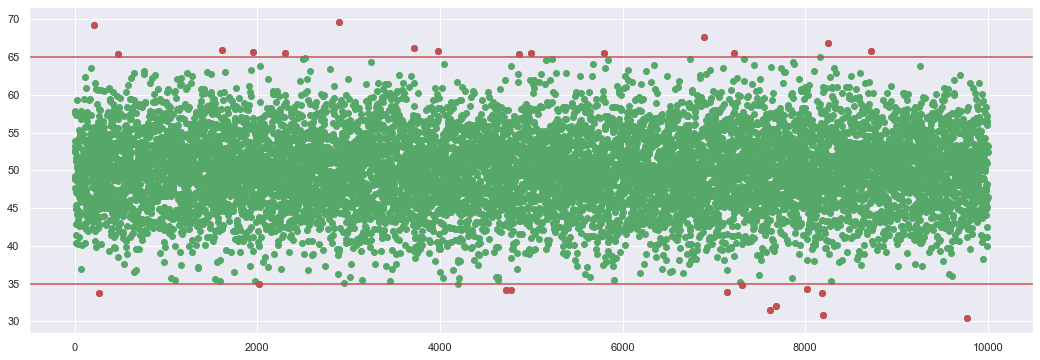

In [7]:
fig,axes = plt.subplots(1,figsize=(18,6))
axes.scatter(np.arange(0,data.shape[0]),data,color='g')
axes.scatter(outliers_idx,data[outliers_idx],color='r')
axes.axhline(lower,color="r");axes.axhline(upper,color="r");

### 7.2 Detección de outliers. Método del rango intercuartil (IQR)

In [8]:
q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
iqr = q75 - q25
cutoff = iqr * 1.5
lower,upper = q25-cutoff, q75+cutoff
outliers_idx = np.argwhere((data<lower) | (data>upper))

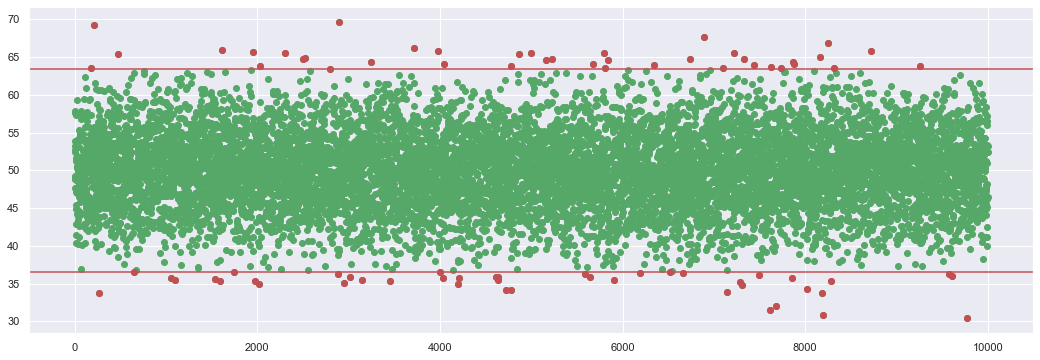

In [9]:
fig,axes = plt.subplots(1,figsize=(18,6))
axes.scatter(np.arange(0,data.shape[0]),data,color='g')
axes.scatter(outliers_idx,data[outliers_idx],color='r')
axes.axhline(lower,color="r");axes.axhline(upper,color="r");

### 7.3 Tratamiento de outliers. Poda (trimming)

Este ejemplo utiliza las funciones de diagnóstico y selección de umbrales introducido en la sección 2 con el dataset de Boston.

En este caso, se eliminarán las muestras que superen los umbrales allados.

In [10]:
def outlier_diagnostic_plots(df, variable):
    fig,axes = plt.subplots(1,3,figsize=(20,4))

    sns.histplot(df[variable], bins=30,ax=axes[0], kde=True)
    axes[0].set_title('Histograma')
    
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    axes[1].set_title('QQ')
    
    # boxplot    
    sns.boxplot(y=df[variable],ax=axes[2])
    axes[2].set_title('Box&Whiskers')

In [11]:
from sklearn.datasets import load_boston

boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]
boston.head()

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


Estudio de outliers.

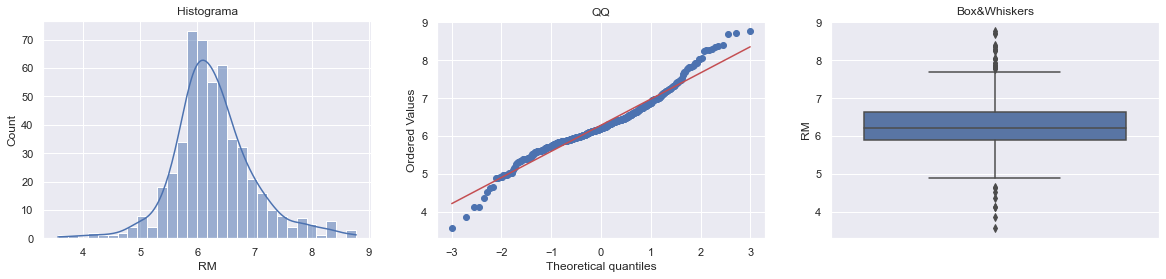

In [12]:
outlier_diagnostic_plots(boston, 'RM')

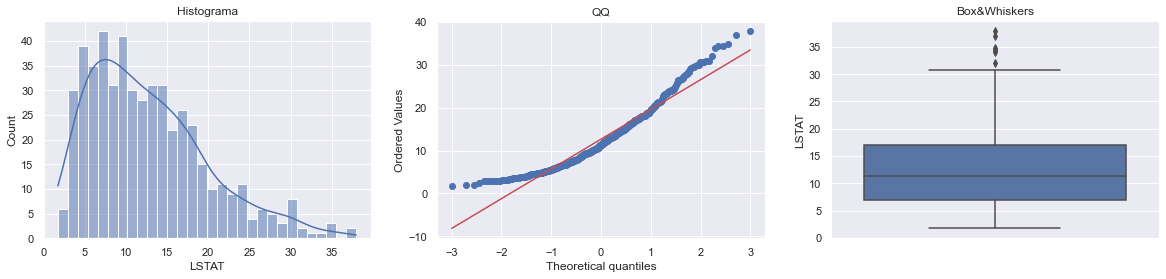

In [13]:
outlier_diagnostic_plots(boston, 'LSTAT')

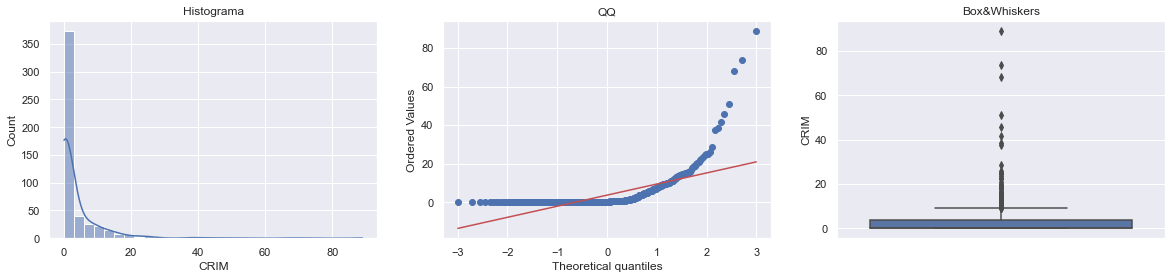

In [14]:
outlier_diagnostic_plots(boston, 'CRIM')

Como las distribuciones tienen oblicuidad, utilizamos el método de distancia IQR para obtener los umbrales para cada variable.

In [15]:
def find_skewed_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

In [16]:
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(boston, 'RM', 1.5)
RM_upper_limit, RM_lower_limit

(7.730499999999999, 4.778500000000001)

In [17]:
LSTAT_upper_limit, LSTAT_lower_limit = find_skewed_boundaries(boston, 'LSTAT', 1.5)
LSTAT_upper_limit, LSTAT_lower_limit

(31.962500000000006, -8.057500000000005)

In [18]:
CRIM_upper_limit, CRIM_lower_limit = find_skewed_boundaries(boston, 'CRIM', 1.5)
CRIM_upper_limit, CRIM_lower_limit

(9.06963875, -5.31051125)

Obtenemos los outliers para cada variable.

In [19]:
outliers_RM = np.where(boston['RM'] > RM_upper_limit, True,
                       np.where(boston['RM'] < RM_lower_limit, True, False))

In [20]:
outliers_LSTAT = np.where(boston['LSTAT'] > LSTAT_upper_limit, True,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, True, False))

In [21]:
outliers_CRIM = np.where(boston['CRIM'] > CRIM_upper_limit, True,
                       np.where(boston['CRIM'] < CRIM_lower_limit, True, False))

Filtramos los valores que no son outliers y guardamos el resultado en un nuevo dataset.

In [22]:
boston_trimmed = boston.loc[~(outliers_RM + outliers_LSTAT + outliers_CRIM), ]
boston.shape, boston_trimmed.shape

((506, 3), (416, 3))

In [23]:
# Porcentaje del dataset original
boston_trimmed.shape[0]/boston.shape[0]

0.8221343873517787

Uno de los inconvenientes de esta aproximación, es que se descartaron casi un 20% de los datos originales.

A continuación se estudiarán las distribuciones luego de la poda de outliers.

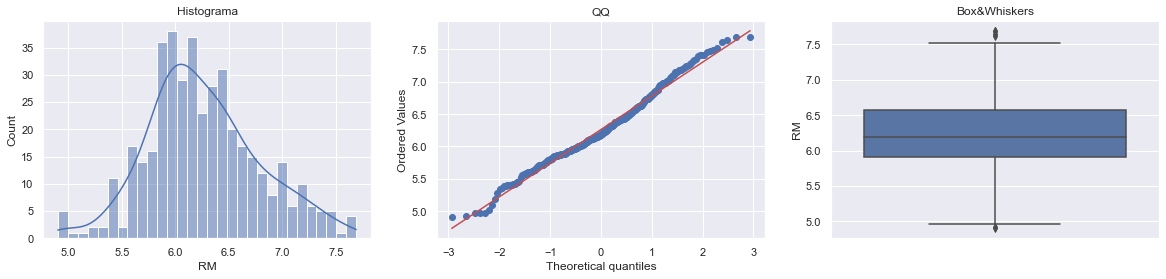

In [24]:
outlier_diagnostic_plots(boston_trimmed, 'RM')

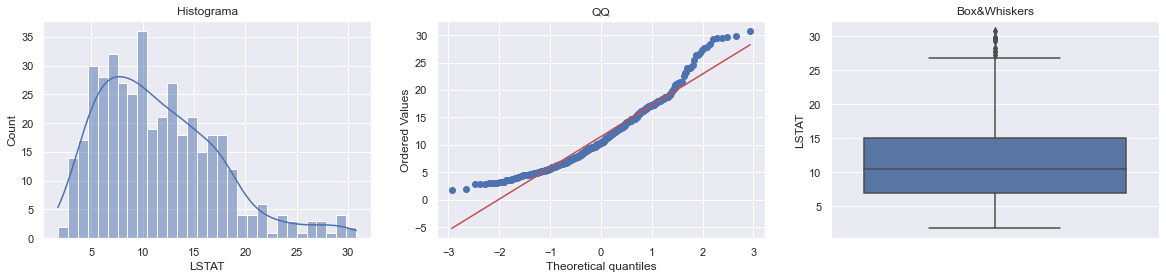

In [25]:
outlier_diagnostic_plots(boston_trimmed, 'LSTAT')

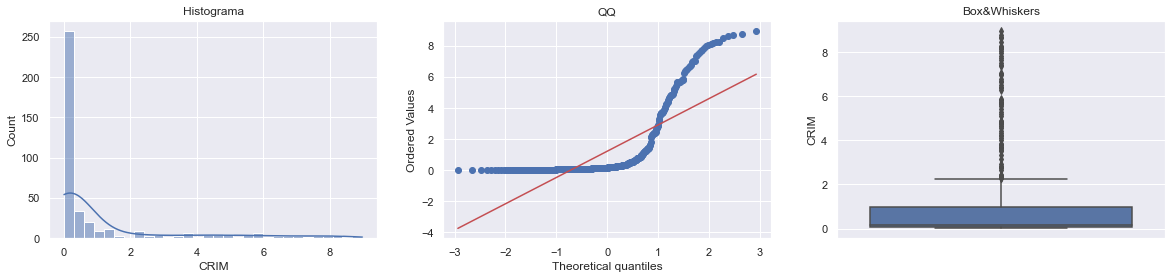

In [26]:
outlier_diagnostic_plots(boston_trimmed, 'CRIM')

Observaciones:
- En RM el resultado es aceptable, la distribución tiene muy pocos valores alejados.
- En LSTAT y CRIM, en cambio, se modificó la distribución y valores que antes no eran considerados outliers pasaron a serlo.

### 7.4 Tratamiento de outliers. Censura (capping)

Repetiremos el procedimiento anterior, pero esta vez utilizando censura.

In [27]:
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

In [28]:
boston['RM']= np.where(boston['RM'] > RM_upper_limit, RM_upper_limit,
                       np.where(boston['RM'] < RM_lower_limit, RM_lower_limit, boston['RM']))

In [29]:
boston['LSTAT']= np.where(boston['LSTAT'] > LSTAT_upper_limit, LSTAT_upper_limit,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, LSTAT_lower_limit, boston['LSTAT']))

In [30]:
boston['CRIM']= np.where(boston['CRIM'] > CRIM_upper_limit, CRIM_upper_limit,
                       np.where(boston['CRIM'] < CRIM_lower_limit, CRIM_lower_limit, boston['CRIM']))

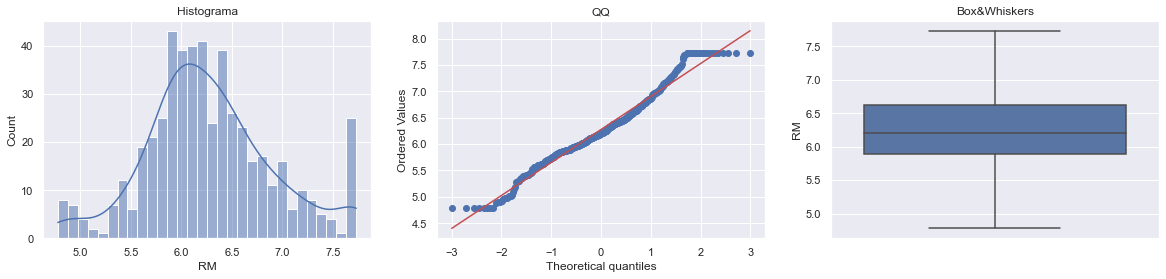

In [31]:
outlier_diagnostic_plots(boston, 'RM')

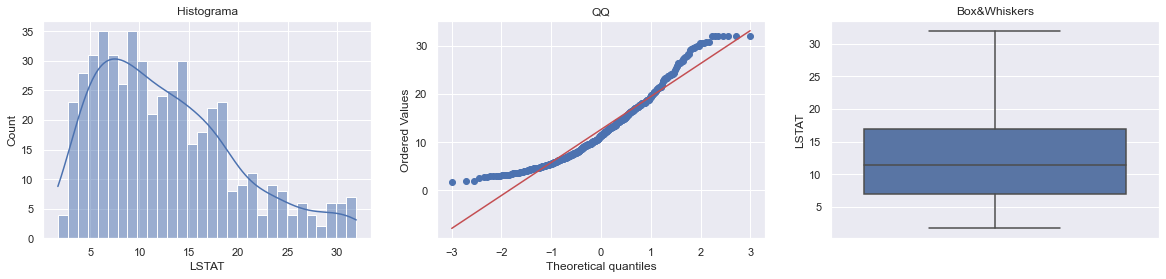

In [32]:
outlier_diagnostic_plots(boston, 'LSTAT')

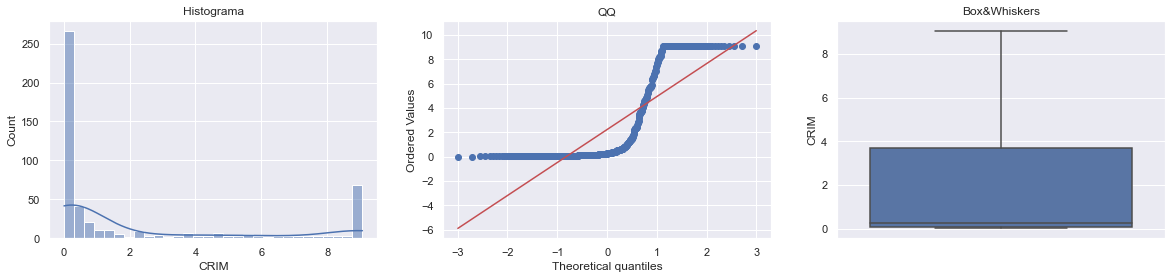

In [33]:
outlier_diagnostic_plots(boston, 'CRIM')

Observación:
- En este caso desaparecieron los outliers, pero con una distorsión importante de la distribución.

### 7.5 Tratamiento de outliers. Eliminación automática

En este ejemplo se utiliza un algoritmo de SKLearn que realiza la eliminación identificando elementos aislados del resto y se compara su efecto en modelo de regresión lineal.

> Unsupervised Outlier Detection using Local Outlier Factor (LOF)

> The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

In [34]:
df = pd.read_csv(DATASET_PATH+'/housing_ex.csv')
df.dropna(inplace=True)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


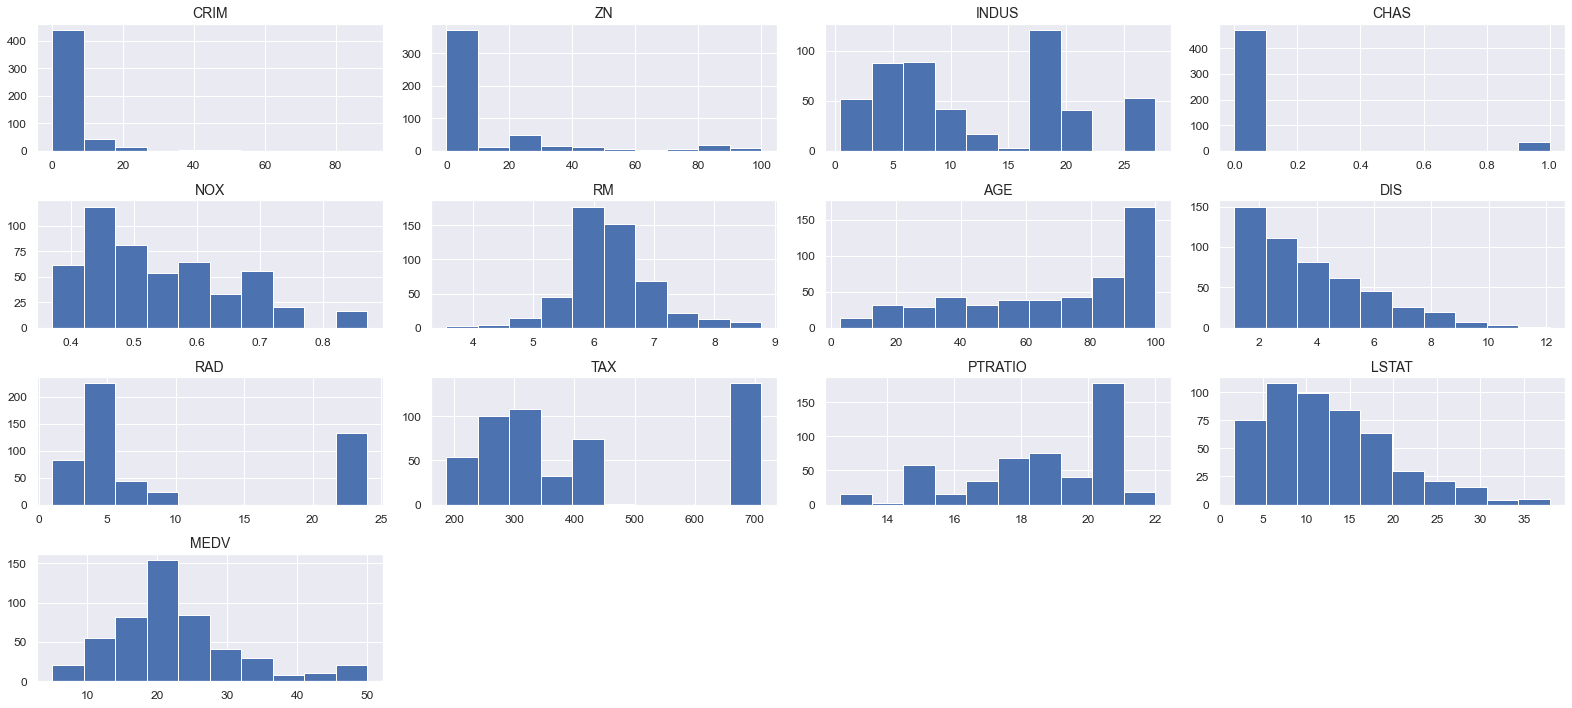

In [35]:
display_dataset_distributions(df)

In [36]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,12.331210,0.069170,0.541737,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,7.735196,0.253994,0.119608,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.370769,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.400000,0.000000,0.437000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,10.010000,0.000000,0.520000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.614000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


In [37]:
X = df.values[:,:-1]
y = df.values[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape,X_test.shape

((354, 12), (152, 12))

In [38]:
from sklearn.metrics import mean_absolute_error

# Entrenar con todos los datos
model = LinearRegression()
model = model.fit(X_train,y_train)

# Predecir en test set
yhat = model.predict(X_test)
mae = mean_absolute_error(y_test, yhat)

print(f"MAE sin eliminar outliers: %.3f" % mae )

MAE sin eliminar outliers: 3.436


In [39]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train) 
outliers_idx = (yhat == -1)

print("Outliers encontrados:",np.sum(outliers_idx))

Outliers encontrados: 30


In [40]:
# Entrenar con los datos sin outliers
model = LinearRegression()
model = model.fit(X_train[~outliers_idx],y_train[~outliers_idx])

# Predecir en test set
yhat = model.predict(X_test)
mae = mean_absolute_error(y_test, yhat)

print(f"MAE eliminando outliers: %.3f" % mae )

MAE eliminando outliers: 3.351
